## Import modules

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import scrublet as scr
import session_info

In [2]:
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi = 160, color_map = 'RdPu', dpi_save = 180, vector_friendly = True, format = 'svg')
session_info.show()

## Functions

## Read in anndata

In [4]:
adata = sc.read_h5ad('/nfs/team205/heart/anndata_objects/Foetal/QC/T21_multiome_RNA_foetal_prefilter.h5ad')
adata

AnnData object with n_obs × n_vars = 190750 × 36601
    obs: 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval'
    var: 'gene_name', 'feature_type', 'ambient_expression-0', 'ambient_expression-1', 'ambient_expression-2', 'ambient_expression-3', 'ambient_expression-4', 'ambient_expression-5', 'ambient_expression-6', 'ambient_expression-7'
    obsm: 'latent_gene_encoding'

In [5]:
adata.obs['combinedID'].value_counts()

BHF_F_Hea13188319_BHF_F_Hea13187621    50000
BHF_F_Hea13188321_BHF_F_Hea13187623    38944
BHF_F_Hea13188325_BHF_F_Hea13187627    23862
BHF_F_Hea13188322_BHF_F_Hea13187624    17452
BHF_F_Hea13188323_BHF_F_Hea13187625    17143
BHF_F_Hea13188327_BHF_F_Hea13187629    16377
BHF_F_Hea13188320_BHF_F_Hea13187622    14000
BHF_F_Hea13188326_BHF_F_Hea13187628    12972
Name: combinedID, dtype: int64

## Remove doublets

<AxesSubplot:>

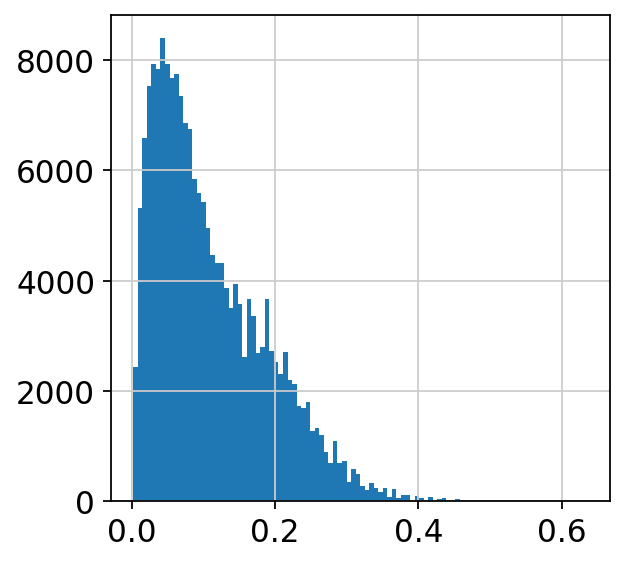

In [6]:
adata.obs['scrublet_score'].hist(bins=100)

In [7]:
# set threshold (arbitrary)
dbl_score_thresh=0.15

prop = np.sum(adata.obs['scrublet_score']>=dbl_score_thresh)/len(adata)
print(f'proportion of doublets: {prop}')

proportion of doublets: 0.2766657929226737


In [8]:
# Save doublet ids
doublets = adata.obs_names[(adata.obs['scrublet_score']<dbl_score_thresh)==False]
with open('/nfs/team205/heart/anndata_objects/Foetal/QC/T21_Multiome_rm-doublets.txt', 'w') as f:
    for line in doublets:
        f.write(line)
        f.write('\n')

# Remove doublets
adata = adata[adata.obs['scrublet_score']<dbl_score_thresh]
print(adata.shape)

(137976, 36601)


## Remove low quality cells

In [9]:
sc.pp.filter_cells(adata, min_genes=500, inplace=True)
sc.pp.filter_cells(adata, min_counts=1000, inplace=True)
adata.shape

filtered out 19359 cells that have less than 500 genes expressed
Trying to set attribute `.obs` of view, copying.
filtered out 7603 cells that have less than 1000 counts


(111014, 36601)

## Compute QC stats

In [10]:
adata.var['mt'] = adata.var['gene_name'].str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
adata.var['ribo'] = adata.var['gene_name'].str.startswith('RPS','RPL')  # annotate the group of ribosomal genes as 'ribo'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt','ribo'], percent_top=None, log1p=True, inplace=True)

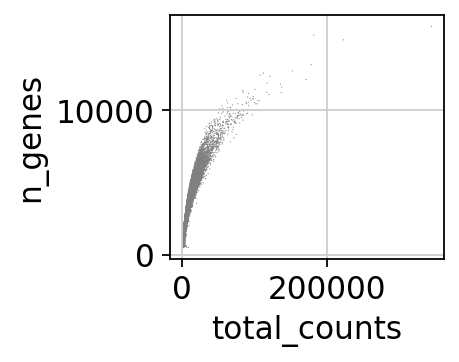

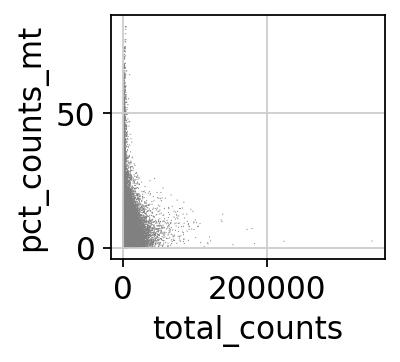

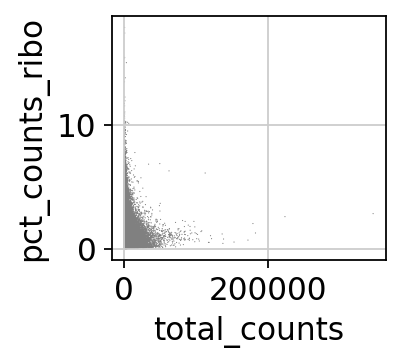

In [11]:
plt.rcParams['figure.figsize'] = [3, 2]

sc.pl.scatter(adata, x='total_counts', y='n_genes')
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='pct_counts_ribo')

## Remove cells exceeding the ribo/mito threshold

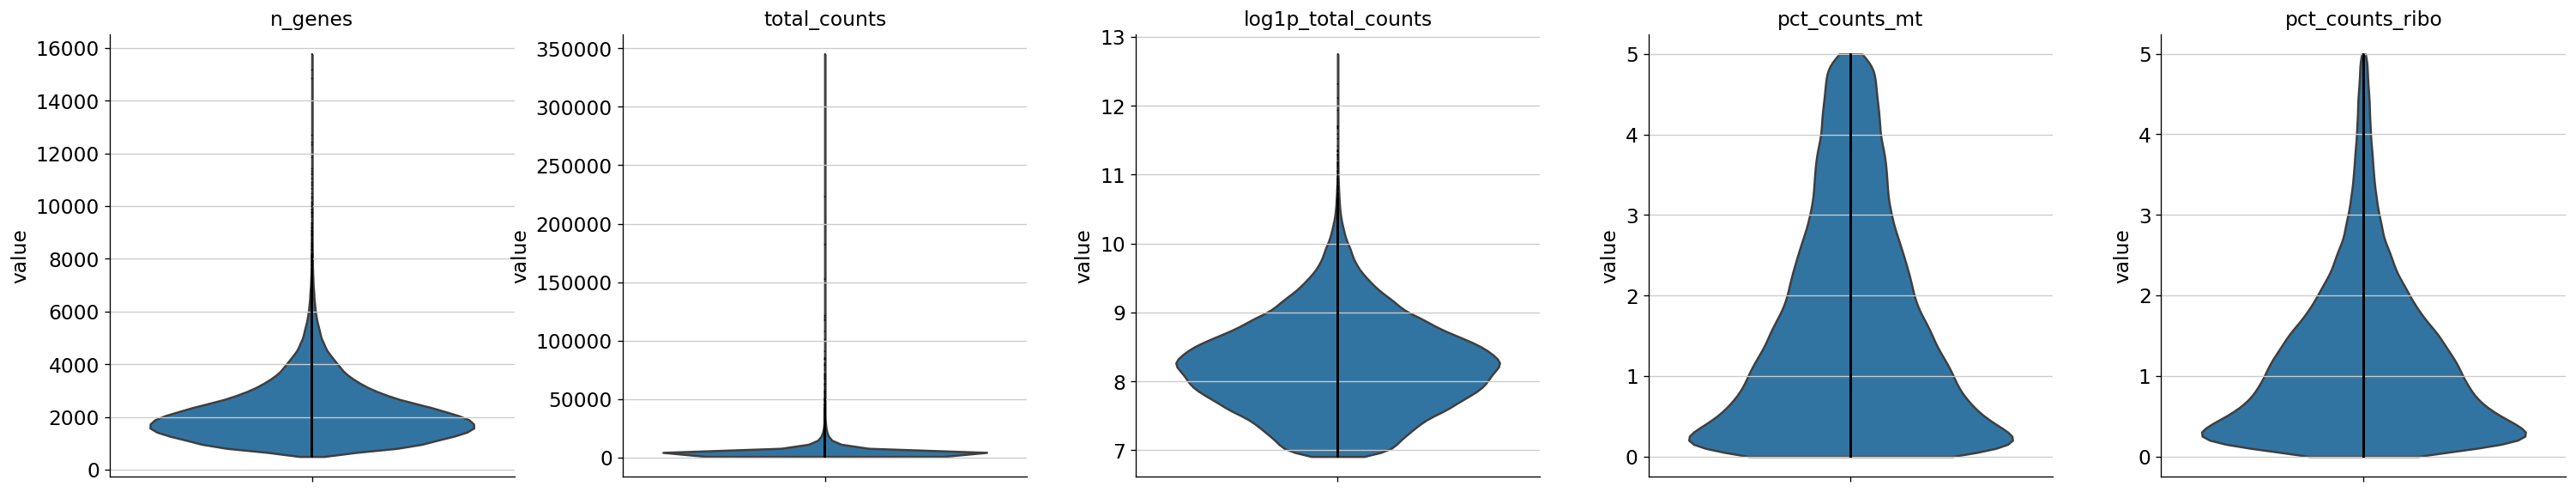

In [18]:
plt.rcParams['figure.figsize'] = [2, 2]
adata = adata[adata.obs['pct_counts_mt'] < 5, :]
adata = adata[adata.obs['pct_counts_ribo'] < 5, :]
sc.pl.violin(adata, ['n_genes', 'total_counts', 'log1p_total_counts','pct_counts_mt', 'pct_counts_ribo'],jitter = 0, multi_panel = True)

Trying to set attribute `.uns` of view, copying.


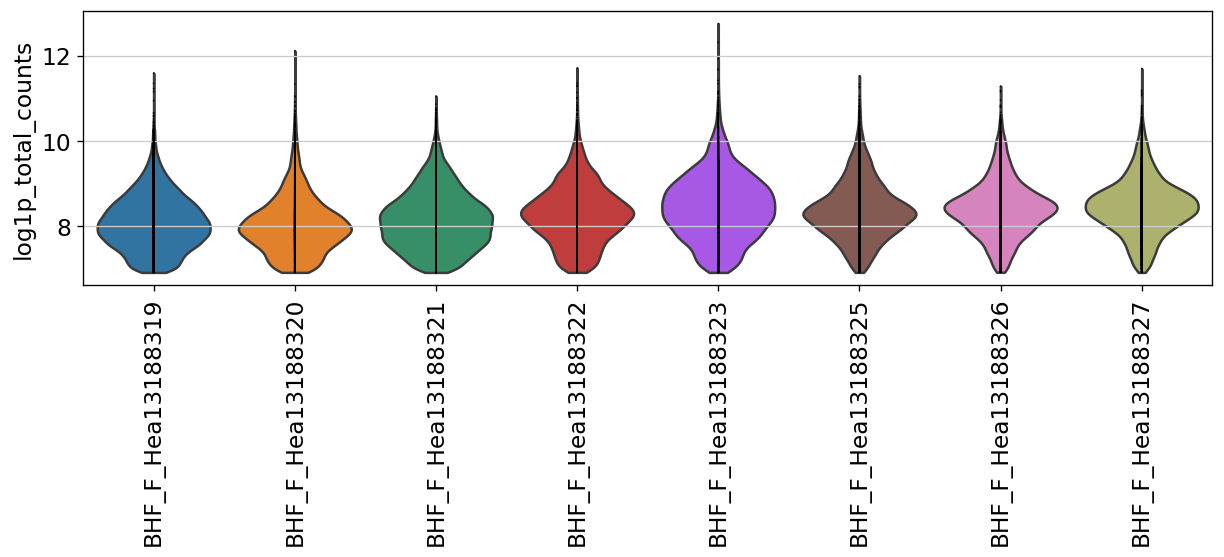

In [13]:
sc.settings.set_figure_params(dpi = 120, color_map = 'RdPu')
plt.rcParams['figure.figsize'] = 10,3
sc.pl.violin(adata,keys=['log1p_total_counts'],groupby='sangerID',rotation=90,jitter=False)

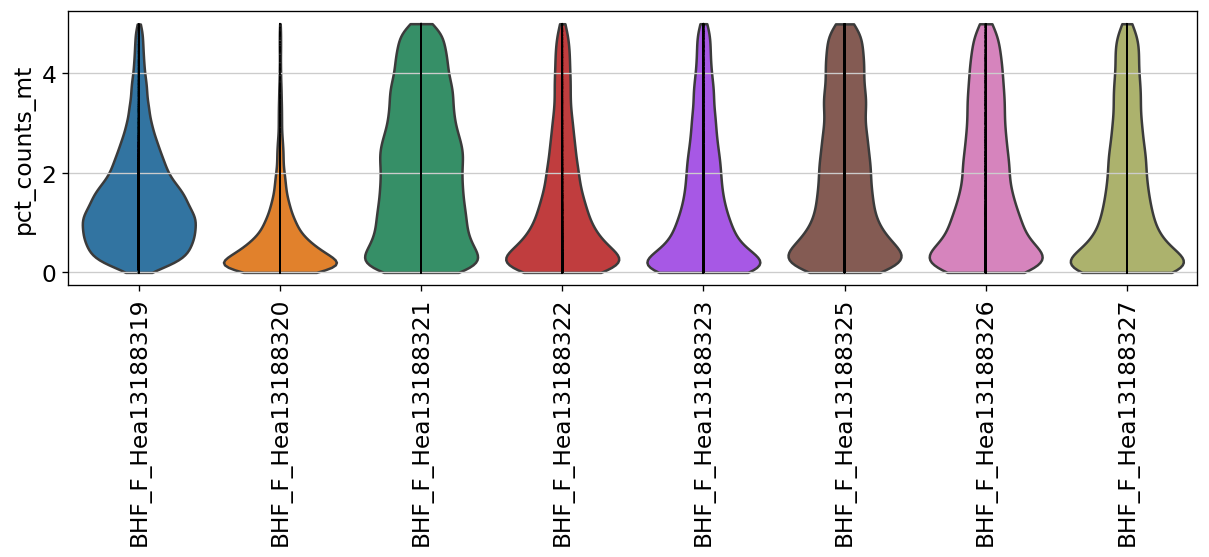

In [14]:
plt.rcParams['figure.figsize'] = 10,3
sc.pl.violin(adata,keys=['pct_counts_mt'],groupby='sangerID',rotation=90,jitter=False)

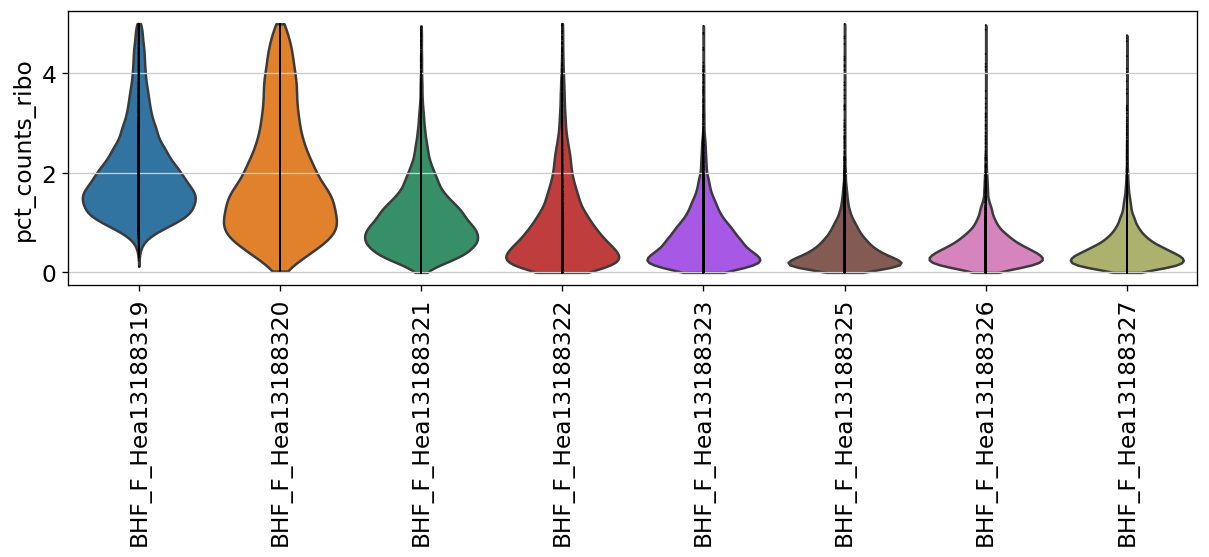

In [15]:
plt.rcParams['figure.figsize'] = 10,3
sc.pl.violin(adata,keys=['pct_counts_ribo'],groupby='sangerID',rotation=90,jitter=False)

In [16]:
sc.settings.set_figure_params(dpi = 120, color_map = 'RdPu')

In [17]:
adata.shape

(84159, 36601)

## Calculate RBC score 

In [19]:
adata_c = adata.copy()

adata_c.var.set_index('gene_name',inplace=True)
adata_c.var_names = adata_c.var_names.astype('str')
adata_c.var_names_make_unique()

sc.pp.filter_genes(adata_c, min_cells=3)
sc.pp.normalize_total(adata_c, target_sum=1e4)
sc.pp.log1p(adata_c)

filtered out 4196 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)


In [20]:
# scoring hemoglobin genes
# HGNC, Hemoglobin subunits, groupID:940
genes=['HBA1','HBA2','HBB','HBD','HBE1','HBG1','HBG2','HBM','HBQ1','HBZ']
sc.tl.score_genes(adata_c,gene_list=genes,score_name='HB_score')

computing score 'HB_score'
    finished: added
    'HB_score', score of gene set (adata.obs).
    400 total control genes are used. (0:00:03)


In [21]:
len(adata_c.obs['sangerID'].unique())

8

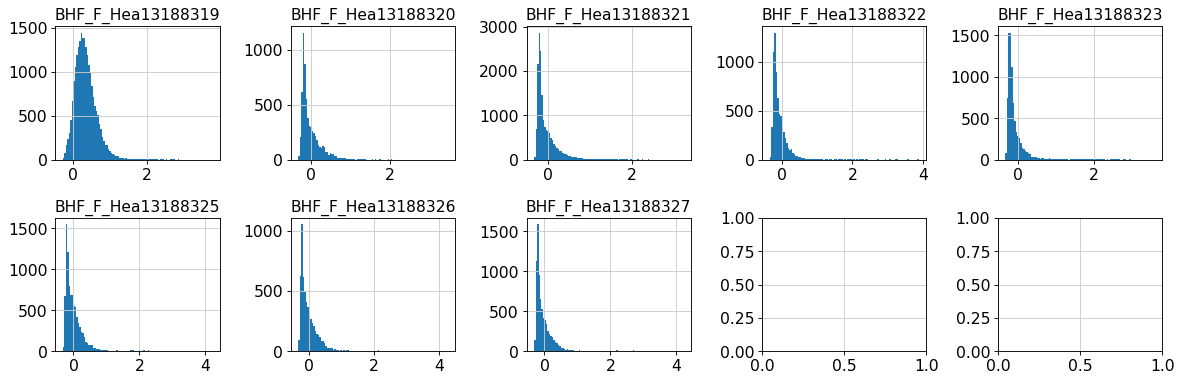

In [25]:
sc.settings.set_figure_params(dpi = 80, color_map = 'RdPu', dpi_save = 180, vector_friendly = True, format = 'svg')

fig,axs=plt.subplots(nrows=2,ncols=5,figsize=(15,5))

for i,ID in enumerate(adata_c.obs['sangerID'].unique()):
    sample = adata_c[adata_c.obs['sangerID']==ID]
    axs[i//5,i%5].hist(sample.obs['HB_score'],bins=100)
    axs[i//5,i%5].set_title(ID)

fig.tight_layout()
plt.show()

In [26]:
# add HB score to original adata
adata.obs.loc[adata_c.obs_names,'HB_score']=adata_c.obs['HB_score']

## Remove RBCs

In [27]:
HBscore_thresh=1

adata=adata[adata.obs['HB_score']<HBscore_thresh]
print(adata.shape)

(82277, 36601)


In [28]:
adata.obs['combinedID'].value_counts()

BHF_F_Hea13188319_BHF_F_Hea13187621    21451
BHF_F_Hea13188321_BHF_F_Hea13187623    16869
BHF_F_Hea13188325_BHF_F_Hea13187627     9103
BHF_F_Hea13188323_BHF_F_Hea13187625     8115
BHF_F_Hea13188327_BHF_F_Hea13187629     7705
BHF_F_Hea13188322_BHF_F_Hea13187624     6868
BHF_F_Hea13188320_BHF_F_Hea13187622     6450
BHF_F_Hea13188326_BHF_F_Hea13187628     5716
Name: combinedID, dtype: int64

## Save post-filtered anndata

In [29]:
# save
adata.write('/nfs/team205/heart/anndata_objects/Foetal/QC/T21_multiome_RNA_foetal.h5ad')
adata

View of AnnData object with n_obs × n_vars = 82277 × 36601
    obs: 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'n_genes', 'n_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'HB_score'
    var: 'gene_name', 'feature_type', 'ambient_expression-0', 'ambient_expression-1', 'ambient_expression-2', 'ambient_expression-3', 'ambient_expression-4', 'ambient_expression-5', 'ambient_expression-6', 'ambient_expression-7', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [3]:
# read in 
adata = sc.read_h5ad('/nfs/team205/heart/anndata_objects/Foetal/QC/T21_multiome_RNA_foetal.h5ad')
adata

AnnData object with n_obs × n_vars = 82277 × 36601
    obs: 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'n_genes', 'n_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'HB_score'
    var: 'gene_name', 'feature_type', 'ambient_expression-0', 'ambient_expression-1', 'ambient_expression-2', 'ambient_expression-3', 'ambient_expression-4', 'ambient_expression-5', 'ambient_expression-6', 'ambient_expression-7', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns

In [4]:
# set batch key and save again
adata.obs['batch_key']=adata.obs['donor'].astype('str')+'_'+adata.obs['cell_or_nuclei'].astype('str')+'_'+adata.obs['kit_10x'].astype('str')

# save
adata.write('/nfs/team205/heart/anndata_objects/Foetal/QC/T21_multiome_RNA_foetal.h5ad')

adata.obs['batch_key'].value_counts()

... storing 'batch_key' as categorical


Hst42_Nuclei_Multiome-v1    59753
Hst44_Nuclei_Multiome-v1    22524
Name: batch_key, dtype: int64

In [ ]:
# rclone to gdrive
rclone copy /nfs/team205/heart/anndata_objects/Foetal/QC/T21_multiome_RNA_foetal.h5ad \
gdrive:JamesC_Kazumasa/Foetal_Heart/SanjayShinha/toSinhalab/anndata/

## Just checking

In [ ]:
adata.obs['combinedID'].value_counts()

In [ ]:
adata.obs['donor'].value_counts()

In [ ]:
pd.crosstab(adata.obs['donor'],adata.obs['age'])

In [ ]:
pd.crosstab(adata.obs['donor'],adata.obs['gender'])

In [ ]:
adata.obs['SOC | status'].value_counts()

In [ ]:
adata.obs[adata.obs['multiplexed']=='Yes']['donor_by_library-prep'].value_counts()